In [15]:
import zipfile
import os
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def un_zip(file_name):
    with zipfile.ZipFile(file_name,'r') as zip_file:
        extract_dir = file_name.rsplit('.',1)[0] + "_files" #创建解压后的文件夹
        if not os.path.isdir(extract_dir):
            os.mkdir(extract_dir)
        zip_file.extractall(extract_dir) #将 zip_file 中的所有文件和目录提取到 extract_dir 目录中
        return extract_dir

def extract_file():
    current_directory = os.getcwd()
    file_path = None
    for file_name in os.listdir(current_directory):
        if file_name.endswith('.zip'):
            file_path = un_zip(file_name)
            print (f'successfully unzip {file_name}')
    return file_path



# dataset

In [21]:
class COVID19Dataset(Dataset):
    def __init__(self,path,mode,target_only=False):
        self.mode = mode
        self.target_only = target_only  #是不是说
        self.file_path = path
        self.X,self.Y = None,None
        self.dim = 0
        train_data_raw = pd.read_csv(os.path.join(file_path,'covid.train.csv')).drop(columns=['id']).values
        test_data_raw = pd.read_csv(os.path.join(file_path,'covid.test.csv')).drop(columns=['id']).values
        if not target_only:
            feats = list(range(93)) #这里的类型是list，为什么
        else: 
            pass
        if self.mode == 'test':
            self.X = test_data_raw[:,:]
            self.X = self.X.astype(float)
            self.X = torch.FloatTensor(self.X)
             #ndarray 
        else:
            if self.mode == 'train':
                self.X,self.Y = train_data_raw[:,:-1],train_data_raw[:,-1] #ndarray   
                self.X = self.X.astype(float)
                self.Y = self.Y.astype(float)
                self.X,self.Y = torch.FloatTensor(self.X),torch.FloatTensor(self.Y)
            elif self.mode == 'dev':
                self.X,self.Y = train_data_raw[:,:-1],train_data_raw[:,-1] #? 
                self.X = self.X.astype(float)
                self.Y = self.Y.astype(float)
                self.X,self.Y = torch.FloatTensor(self.X),torch.FloatTensor(self.Y)
        self.normalize(self.X,self.Y)     
        self.dim = self.X.shape[1]
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
          .format(mode, len(self.X), self.X.shape[1]))
        
    def normalize(self,X,Y = None):
        if X is not None:
            means = self.X.mean(dim=0, keepdim=True)
            stds = self.X.std(dim=0, keepdim=True)
            self.X = (self.X - means) / stds
        else:
            print('waring! Invalid input! check your data!')
            
            
    def __getitem__(self,idx):
        if self.Y is None:
            return self.X[idx]
        else:
            return self.X[idx],self.Y[idx]
    
    def __len__(self):
        return len(self.X)
    
    def data_set(self,file_path):
        print(self.X.shape)
        print(self.Y.shape)
        # print(test_data_raw.shape)
        

#  utilities


In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()    

# dataloader

In [4]:
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
    dataset = COVID19Dataset(path,mode=mode,target_only=target_only)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True) # Construct dataloader
    return dataloader

# Neural Network

In [5]:
class NeuralNet(nn.Module):
    def __init__(self,input_dim):
        super(NeuralNet,self).__init__() #为什么不是nn.moudle
        self.net = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.criterion = nn.MSELoss(reduction='mean')  #criterion 通常是损失函数啦
        
    def forward(self,x):
        output = self.net(x)
        # print("Output without squeeze: ",output)
        return output.squeeze(1) #不知道为什么移除了一个维度
    def cal_loss(self,pred,target):   #prediction
        return self.criterion(pred,target)

# setup Hyper-parameters

In [6]:
device = get_device()
target_only = False

config = {
    'n_epochs':3000,
    'batch_size':30,
    'optimizer':'SGD',#
    'optim_hparas':{
        'lr' : 1e-4,
        'momentum':0.9
    },
    'early_stop':200
}

# Training

In [7]:

def train(model,train_set,dev_set,config,device):  #使用trainset的话，应该要求trainset是dataloader的数据类型
    #train_data 和 train_labels 就是
    '''
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-6,momentum=0.9)
    '''
    optimizer = getattr(torch.optim,config['optimizer'])(model.parameters(),**config['optim_hparas'])
    n_epochs = config['n_epochs']
    loss_record = {'train':[],'dev':[]}
    min_mse = 1200
    early_stop_cnt = 0
    for epoch in range(n_epochs):
        model.train()
        for x,y in train_set:
            optimizer.zero_grad()
            x,y = x.to(device) , y.to(device)
            pred = model(x)
            mse_loss = model.cal_loss(pred,y) 
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())  #这个是什么意思
            
            dev_mse = dev(dev_set,model,device)
            if dev_mse < min_mse:
                min_mse = dev_mse
                print(f'Epoch [{epoch+1}], Train Loss: {loss_record["train"][-1]:.4f}, Dev MSE: {dev_mse:.4f}')
                early_stop_cnt = 0
            else:
                early_stop_cnt += 1
            loss_record['dev'].append(dev_mse)
            if early_stop_cnt > config['early_stop']:
                print(f'Early stopping at epoch {epoch+1}')
                break
    print('finish training after {} epochs'.format(epoch))
    return min_mse,loss_record

# validation

In [8]:
def dev(dv_set , model , device):
    model.eval()
    total_loss = 0
    for x,y in dv_set:
        x,y = x.to(device) , y.to(device)
        with torch.no_grad():
            pred = model(x)
            mse_loss = model.cal_loss(pred,y) #mse_loss 是模型在当前批次中预测值 pred 和实际标签 y 之间的均方误差损失
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss/len(dv_set.dataset)
    
    return total_loss

# Testing

In [19]:
def test(test_set,model,device):
    model.eval()
    preds = []
    for x in test_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds,dim=0).numpy()
    return preds

# load data and model

In [33]:
if __name__ == "__main__":
    file_path = extract_file()  #含有三个文件的文件夹
    dataset = COVID19Dataset(file_path,'train') #
    tr_set = prep_dataloader(file_path,'train',config['batch_size'],target_only=target_only)
    for batch_data,a in tr_set:
        print(f"Batch data shape: {batch_data.shape}")
        input_feature_dim = batch_data.shape[1]
    dv_set = prep_dataloader(file_path,'dev',config['batch_size'],target_only=target_only)
    tt_set = prep_dataloader(file_path,'test',config['batch_size'],target_only=target_only)
    for batch_data in tt_set:
        print(f"Batch data shape: {batch_data.shape}")
    # 确认输入数据的特征数是否符合模型的预期输入
        input_feature_dim = batch_data.shape[1]
        print(f"Input feature dimension: {input_feature_dim}")
        break  # 只打印第一个批次的形状
    model = NeuralNet(tr_set.dataset.dim).to(device)  # 这个dim是什么意思

successfully unzip ml2021spring-hw1.zip
Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 93)
Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 93)
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch data shape: torch.Size([30, 93])
Batch da

# Start !

In [11]:
model_loss,model_loss_record = train(model,tr_set,dv_set,config,device)

Epoch [1], Train Loss: 286.3881, Dev MSE: 323.8066
Epoch [1], Train Loss: 332.6741, Dev MSE: 322.6192
Epoch [1], Train Loss: 217.7854, Dev MSE: 321.1062
Epoch [1], Train Loss: 336.4190, Dev MSE: 319.0608
Epoch [1], Train Loss: 330.0510, Dev MSE: 316.5744
Epoch [1], Train Loss: 251.0021, Dev MSE: 313.8313
Epoch [1], Train Loss: 298.9388, Dev MSE: 310.7899
Epoch [1], Train Loss: 324.6241, Dev MSE: 307.4071
Epoch [1], Train Loss: 231.1916, Dev MSE: 303.8140
Epoch [1], Train Loss: 255.8874, Dev MSE: 299.9791
Epoch [1], Train Loss: 329.2209, Dev MSE: 295.8378
Epoch [1], Train Loss: 335.7245, Dev MSE: 291.3532
Epoch [1], Train Loss: 246.5681, Dev MSE: 286.6899
Epoch [1], Train Loss: 277.7033, Dev MSE: 281.7001
Epoch [1], Train Loss: 361.2787, Dev MSE: 276.1977
Epoch [1], Train Loss: 217.4365, Dev MSE: 270.6295
Epoch [1], Train Loss: 346.2010, Dev MSE: 264.4331
Epoch [1], Train Loss: 222.2097, Dev MSE: 258.0036
Epoch [1], Train Loss: 322.5630, Dev MSE: 251.0174
Epoch [1], Train Loss: 185.4343

Epoch [2], Train Loss: 5.5650, Dev MSE: 6.8839
Epoch [2], Train Loss: 8.7579, Dev MSE: 6.8440
Epoch [2], Train Loss: 5.8469, Dev MSE: 6.8047
Epoch [2], Train Loss: 6.2565, Dev MSE: 6.7696
Epoch [2], Train Loss: 5.5080, Dev MSE: 6.7333
Epoch [2], Train Loss: 5.1771, Dev MSE: 6.6975
Epoch [2], Train Loss: 5.3885, Dev MSE: 6.6638
Epoch [2], Train Loss: 5.9769, Dev MSE: 6.6312
Epoch [2], Train Loss: 6.0390, Dev MSE: 6.5968
Epoch [3], Train Loss: 9.0828, Dev MSE: 6.5639
Epoch [3], Train Loss: 13.1939, Dev MSE: 6.5293
Epoch [3], Train Loss: 5.0105, Dev MSE: 6.4956
Epoch [3], Train Loss: 5.2130, Dev MSE: 6.4648
Epoch [3], Train Loss: 5.5981, Dev MSE: 6.4376
Epoch [3], Train Loss: 4.1016, Dev MSE: 6.4137
Epoch [3], Train Loss: 6.8227, Dev MSE: 6.3893
Epoch [3], Train Loss: 4.4722, Dev MSE: 6.3662
Epoch [3], Train Loss: 10.5161, Dev MSE: 6.3400
Epoch [3], Train Loss: 3.0540, Dev MSE: 6.3168
Epoch [3], Train Loss: 9.4794, Dev MSE: 6.2917
Epoch [3], Train Loss: 6.9488, Dev MSE: 6.2642
Epoch [3], 

Epoch [4], Train Loss: 4.7406, Dev MSE: 3.8752
Epoch [4], Train Loss: 4.4281, Dev MSE: 3.8691
Epoch [4], Train Loss: 3.3193, Dev MSE: 3.8674
Epoch [4], Train Loss: 5.0146, Dev MSE: 3.8644
Epoch [4], Train Loss: 3.1653, Dev MSE: 3.8633
Epoch [4], Train Loss: 5.2971, Dev MSE: 3.8576
Epoch [4], Train Loss: 3.6878, Dev MSE: 3.8506
Epoch [4], Train Loss: 1.7799, Dev MSE: 3.8443
Epoch [4], Train Loss: 3.4084, Dev MSE: 3.8350
Epoch [4], Train Loss: 3.2458, Dev MSE: 3.8250
Epoch [4], Train Loss: 4.9530, Dev MSE: 3.8152
Epoch [4], Train Loss: 3.5954, Dev MSE: 3.8058
Epoch [4], Train Loss: 4.2926, Dev MSE: 3.7955
Epoch [4], Train Loss: 3.5794, Dev MSE: 3.7826
Epoch [5], Train Loss: 3.4181, Dev MSE: 3.7696
Epoch [5], Train Loss: 3.2171, Dev MSE: 3.7565
Epoch [5], Train Loss: 4.1785, Dev MSE: 3.7419
Epoch [5], Train Loss: 4.4920, Dev MSE: 3.7302
Epoch [5], Train Loss: 4.0495, Dev MSE: 3.7196
Epoch [5], Train Loss: 4.2146, Dev MSE: 3.7094
Epoch [5], Train Loss: 1.6189, Dev MSE: 3.7003
Epoch [5], Tr

Epoch [7], Train Loss: 2.2972, Dev MSE: 2.6707
Epoch [7], Train Loss: 1.4657, Dev MSE: 2.6685
Epoch [7], Train Loss: 3.4216, Dev MSE: 2.6647
Epoch [7], Train Loss: 1.9354, Dev MSE: 2.6596
Epoch [7], Train Loss: 4.7392, Dev MSE: 2.6564
Epoch [7], Train Loss: 3.6462, Dev MSE: 2.6550
Epoch [7], Train Loss: 1.4365, Dev MSE: 2.6540
Epoch [7], Train Loss: 3.0947, Dev MSE: 2.6520
Epoch [7], Train Loss: 2.5429, Dev MSE: 2.6506
Epoch [7], Train Loss: 3.0743, Dev MSE: 2.6422
Epoch [7], Train Loss: 2.1500, Dev MSE: 2.6336
Epoch [7], Train Loss: 3.1999, Dev MSE: 2.6239
Epoch [7], Train Loss: 2.1363, Dev MSE: 2.6141
Epoch [7], Train Loss: 3.2229, Dev MSE: 2.6040
Epoch [7], Train Loss: 2.0988, Dev MSE: 2.5958
Epoch [7], Train Loss: 2.1505, Dev MSE: 2.5900
Epoch [7], Train Loss: 2.7500, Dev MSE: 2.5848
Epoch [7], Train Loss: 3.5483, Dev MSE: 2.5807
Epoch [7], Train Loss: 2.2055, Dev MSE: 2.5781
Epoch [7], Train Loss: 2.6765, Dev MSE: 2.5758
Epoch [7], Train Loss: 2.4744, Dev MSE: 2.5742
Epoch [7], Tr

Epoch [9], Train Loss: 1.9935, Dev MSE: 2.0139
Epoch [10], Train Loss: 2.1704, Dev MSE: 2.0127
Epoch [10], Train Loss: 2.6485, Dev MSE: 2.0010
Epoch [10], Train Loss: 1.8201, Dev MSE: 1.9926
Epoch [10], Train Loss: 2.0960, Dev MSE: 1.9867
Epoch [10], Train Loss: 1.4866, Dev MSE: 1.9829
Epoch [10], Train Loss: 2.1700, Dev MSE: 1.9798
Epoch [10], Train Loss: 2.4823, Dev MSE: 1.9781
Epoch [10], Train Loss: 1.4950, Dev MSE: 1.9772
Epoch [10], Train Loss: 3.4659, Dev MSE: 1.9725
Epoch [10], Train Loss: 2.6456, Dev MSE: 1.9677
Epoch [10], Train Loss: 2.0014, Dev MSE: 1.9653
Epoch [10], Train Loss: 1.4512, Dev MSE: 1.9617
Epoch [10], Train Loss: 1.9948, Dev MSE: 1.9562
Epoch [10], Train Loss: 1.9144, Dev MSE: 1.9506
Epoch [10], Train Loss: 2.2566, Dev MSE: 1.9417
Epoch [10], Train Loss: 2.1479, Dev MSE: 1.9328
Epoch [10], Train Loss: 1.2002, Dev MSE: 1.9257
Epoch [10], Train Loss: 1.4845, Dev MSE: 1.9205
Epoch [10], Train Loss: 2.6345, Dev MSE: 1.9176
Epoch [10], Train Loss: 2.0964, Dev MSE: 

Epoch [13], Train Loss: 2.2549, Dev MSE: 1.6093
Epoch [13], Train Loss: 1.5517, Dev MSE: 1.6045
Epoch [13], Train Loss: 0.9068, Dev MSE: 1.6010
Epoch [13], Train Loss: 2.2279, Dev MSE: 1.5964
Epoch [13], Train Loss: 1.8910, Dev MSE: 1.5938
Epoch [13], Train Loss: 1.8700, Dev MSE: 1.5923
Epoch [13], Train Loss: 1.7173, Dev MSE: 1.5916
Epoch [13], Train Loss: 1.4122, Dev MSE: 1.5915
Epoch [13], Train Loss: 1.4503, Dev MSE: 1.5891
Epoch [13], Train Loss: 1.9178, Dev MSE: 1.5869
Epoch [13], Train Loss: 1.4465, Dev MSE: 1.5842
Epoch [13], Train Loss: 1.1677, Dev MSE: 1.5832
Epoch [13], Train Loss: 2.3428, Dev MSE: 1.5829
Epoch [13], Train Loss: 1.9675, Dev MSE: 1.5787
Epoch [14], Train Loss: 1.9021, Dev MSE: 1.5754
Epoch [14], Train Loss: 2.0051, Dev MSE: 1.5733
Epoch [14], Train Loss: 1.7309, Dev MSE: 1.5711
Epoch [14], Train Loss: 1.3618, Dev MSE: 1.5703
Epoch [14], Train Loss: 1.7528, Dev MSE: 1.5674
Epoch [14], Train Loss: 1.6870, Dev MSE: 1.5648
Epoch [14], Train Loss: 2.0859, Dev MSE:

Epoch [18], Train Loss: 0.9463, Dev MSE: 1.3312
Epoch [18], Train Loss: 1.2962, Dev MSE: 1.3308
Epoch [18], Train Loss: 1.0764, Dev MSE: 1.3304
Epoch [18], Train Loss: 2.1804, Dev MSE: 1.3298
Epoch [18], Train Loss: 2.1527, Dev MSE: 1.3295
Epoch [19], Train Loss: 2.0998, Dev MSE: 1.3285
Epoch [19], Train Loss: 1.0929, Dev MSE: 1.3281
Epoch [19], Train Loss: 0.8486, Dev MSE: 1.3281
Epoch [19], Train Loss: 1.7233, Dev MSE: 1.3271
Epoch [19], Train Loss: 1.1261, Dev MSE: 1.3268
Epoch [19], Train Loss: 1.8036, Dev MSE: 1.3244
Epoch [19], Train Loss: 1.5632, Dev MSE: 1.3222
Epoch [19], Train Loss: 1.3529, Dev MSE: 1.3196
Epoch [19], Train Loss: 1.8449, Dev MSE: 1.3179
Epoch [19], Train Loss: 1.4689, Dev MSE: 1.3168
Epoch [19], Train Loss: 1.6196, Dev MSE: 1.3167
Epoch [19], Train Loss: 0.7945, Dev MSE: 1.3155
Epoch [19], Train Loss: 1.2494, Dev MSE: 1.3135
Epoch [19], Train Loss: 1.3108, Dev MSE: 1.3111
Epoch [19], Train Loss: 1.2634, Dev MSE: 1.3085
Epoch [19], Train Loss: 0.9024, Dev MSE:

Epoch [25], Train Loss: 1.4376, Dev MSE: 1.1688
Epoch [25], Train Loss: 0.8328, Dev MSE: 1.1677
Epoch [25], Train Loss: 1.2464, Dev MSE: 1.1670
Epoch [25], Train Loss: 1.3009, Dev MSE: 1.1663
Epoch [25], Train Loss: 0.6973, Dev MSE: 1.1659
Epoch [25], Train Loss: 1.1750, Dev MSE: 1.1657
Epoch [25], Train Loss: 1.1980, Dev MSE: 1.1653
Epoch [25], Train Loss: 1.0133, Dev MSE: 1.1647
Epoch [25], Train Loss: 1.3376, Dev MSE: 1.1646
Epoch [25], Train Loss: 1.4563, Dev MSE: 1.1643
Epoch [25], Train Loss: 1.7586, Dev MSE: 1.1632
Epoch [25], Train Loss: 1.4311, Dev MSE: 1.1620
Epoch [25], Train Loss: 0.8756, Dev MSE: 1.1612
Epoch [25], Train Loss: 1.1898, Dev MSE: 1.1606
Epoch [25], Train Loss: 0.7657, Dev MSE: 1.1603
Epoch [25], Train Loss: 0.7759, Dev MSE: 1.1599
Epoch [25], Train Loss: 0.9414, Dev MSE: 1.1586
Epoch [25], Train Loss: 0.6742, Dev MSE: 1.1582
Epoch [25], Train Loss: 2.0348, Dev MSE: 1.1581
Epoch [25], Train Loss: 1.5145, Dev MSE: 1.1578
Epoch [25], Train Loss: 1.1322, Dev MSE:

Epoch [36], Train Loss: 1.0570, Dev MSE: 1.0192
Epoch [36], Train Loss: 1.3937, Dev MSE: 1.0188
Epoch [36], Train Loss: 0.9063, Dev MSE: 1.0186
Epoch [36], Train Loss: 0.7691, Dev MSE: 1.0178
Epoch [36], Train Loss: 0.7007, Dev MSE: 1.0169
Epoch [36], Train Loss: 1.5941, Dev MSE: 1.0158
Epoch [36], Train Loss: 1.2001, Dev MSE: 1.0152
Epoch [36], Train Loss: 0.4816, Dev MSE: 1.0152
Epoch [36], Train Loss: 1.8764, Dev MSE: 1.0150
Epoch [36], Train Loss: 0.6455, Dev MSE: 1.0147
Epoch [36], Train Loss: 1.6906, Dev MSE: 1.0140
Epoch [36], Train Loss: 0.4621, Dev MSE: 1.0134
Epoch [36], Train Loss: 1.1413, Dev MSE: 1.0133
Epoch [37], Train Loss: 1.2173, Dev MSE: 1.0125
Epoch [37], Train Loss: 0.9031, Dev MSE: 1.0115
Epoch [37], Train Loss: 0.7254, Dev MSE: 1.0109
Epoch [37], Train Loss: 0.7522, Dev MSE: 1.0108
Epoch [37], Train Loss: 0.8952, Dev MSE: 1.0106
Epoch [37], Train Loss: 1.2519, Dev MSE: 1.0101
Epoch [37], Train Loss: 1.2280, Dev MSE: 1.0091
Epoch [38], Train Loss: 0.8393, Dev MSE:

Epoch [56], Train Loss: 0.6075, Dev MSE: 0.8927
Epoch [56], Train Loss: 1.6095, Dev MSE: 0.8918
Epoch [56], Train Loss: 0.8063, Dev MSE: 0.8911
Epoch [57], Train Loss: 1.1017, Dev MSE: 0.8902
Epoch [57], Train Loss: 0.5599, Dev MSE: 0.8891
Epoch [58], Train Loss: 1.1409, Dev MSE: 0.8889
Epoch [58], Train Loss: 1.1263, Dev MSE: 0.8874
Epoch [58], Train Loss: 0.6812, Dev MSE: 0.8867
Epoch [59], Train Loss: 1.0020, Dev MSE: 0.8863
Epoch [59], Train Loss: 0.7880, Dev MSE: 0.8852
Epoch [59], Train Loss: 0.9411, Dev MSE: 0.8844
Epoch [59], Train Loss: 0.8113, Dev MSE: 0.8825
Epoch [59], Train Loss: 0.6732, Dev MSE: 0.8818
Epoch [59], Train Loss: 0.8514, Dev MSE: 0.8816
Epoch [59], Train Loss: 1.1706, Dev MSE: 0.8801
Epoch [59], Train Loss: 1.1285, Dev MSE: 0.8788
Epoch [59], Train Loss: 1.0564, Dev MSE: 0.8782
Epoch [59], Train Loss: 0.8855, Dev MSE: 0.8780
Epoch [60], Train Loss: 1.4663, Dev MSE: 0.8776
Epoch [60], Train Loss: 0.6294, Dev MSE: 0.8769
Epoch [60], Train Loss: 0.7510, Dev MSE:

Epoch [89], Train Loss: 0.5544, Dev MSE: 0.7919
Epoch [89], Train Loss: 1.3701, Dev MSE: 0.7899
Epoch [89], Train Loss: 0.4717, Dev MSE: 0.7886
Epoch [89], Train Loss: 0.6217, Dev MSE: 0.7877
Epoch [89], Train Loss: 0.9117, Dev MSE: 0.7876
Epoch [90], Train Loss: 0.6692, Dev MSE: 0.7871
Epoch [90], Train Loss: 1.0924, Dev MSE: 0.7871
Epoch [90], Train Loss: 0.8370, Dev MSE: 0.7869
Epoch [90], Train Loss: 1.2621, Dev MSE: 0.7865
Epoch [90], Train Loss: 0.7602, Dev MSE: 0.7860
Epoch [90], Train Loss: 1.2480, Dev MSE: 0.7851
Epoch [90], Train Loss: 0.9847, Dev MSE: 0.7846
Early stopping at epoch 93
Early stopping at epoch 94
Early stopping at epoch 95
Early stopping at epoch 96
Early stopping at epoch 97
Early stopping at epoch 98
Early stopping at epoch 99
Early stopping at epoch 100
Early stopping at epoch 101
Early stopping at epoch 102
Early stopping at epoch 103
Early stopping at epoch 104
Early stopping at epoch 105
Early stopping at epoch 106
Early stopping at epoch 107
Early stopp

Epoch [299], Train Loss: 0.5950, Dev MSE: 0.7542
Epoch [299], Train Loss: 1.0761, Dev MSE: 0.7528
Epoch [299], Train Loss: 0.9254, Dev MSE: 0.7520
Epoch [301], Train Loss: 0.7755, Dev MSE: 0.7516
Epoch [301], Train Loss: 1.1043, Dev MSE: 0.7515
Epoch [301], Train Loss: 0.7498, Dev MSE: 0.7508
Epoch [302], Train Loss: 0.8336, Dev MSE: 0.7503
Epoch [303], Train Loss: 0.6003, Dev MSE: 0.7502
Epoch [303], Train Loss: 1.5554, Dev MSE: 0.7497
Epoch [304], Train Loss: 0.9874, Dev MSE: 0.7493
Epoch [304], Train Loss: 0.7127, Dev MSE: 0.7490
Epoch [304], Train Loss: 0.9356, Dev MSE: 0.7482
Epoch [304], Train Loss: 0.4984, Dev MSE: 0.7476
Epoch [304], Train Loss: 0.9938, Dev MSE: 0.7463
Epoch [304], Train Loss: 0.5789, Dev MSE: 0.7455
Epoch [304], Train Loss: 0.5722, Dev MSE: 0.7448
Epoch [304], Train Loss: 1.1556, Dev MSE: 0.7444
Epoch [304], Train Loss: 0.4963, Dev MSE: 0.7442
Epoch [305], Train Loss: 0.5441, Dev MSE: 0.7438
Epoch [305], Train Loss: 0.8946, Dev MSE: 0.7437
Epoch [306], Train L

Early stopping at epoch 519
Early stopping at epoch 520
Early stopping at epoch 521
Early stopping at epoch 522
Early stopping at epoch 523
Early stopping at epoch 524
Early stopping at epoch 525
Early stopping at epoch 526
Early stopping at epoch 527
Early stopping at epoch 528
Early stopping at epoch 529
Early stopping at epoch 530
Early stopping at epoch 531
Early stopping at epoch 532
Early stopping at epoch 533
Early stopping at epoch 534
Early stopping at epoch 535
Early stopping at epoch 536
Early stopping at epoch 537
Early stopping at epoch 538
Early stopping at epoch 539
Early stopping at epoch 540
Early stopping at epoch 541
Early stopping at epoch 542
Early stopping at epoch 543
Early stopping at epoch 544
Early stopping at epoch 545
Early stopping at epoch 546
Early stopping at epoch 547
Early stopping at epoch 548
Early stopping at epoch 549
Early stopping at epoch 550
Early stopping at epoch 551
Early stopping at epoch 552
Early stopping at epoch 553
Early stopping at ep

Early stopping at epoch 789
Early stopping at epoch 790
Early stopping at epoch 791
Early stopping at epoch 792
Early stopping at epoch 793
Early stopping at epoch 794
Early stopping at epoch 795
Early stopping at epoch 796
Early stopping at epoch 797
Early stopping at epoch 798
Early stopping at epoch 799
Early stopping at epoch 800
Early stopping at epoch 801
Early stopping at epoch 802
Early stopping at epoch 803
Early stopping at epoch 804
Early stopping at epoch 805
Early stopping at epoch 806
Early stopping at epoch 807
Early stopping at epoch 808
Early stopping at epoch 809
Early stopping at epoch 810
Early stopping at epoch 811
Early stopping at epoch 812
Early stopping at epoch 813
Early stopping at epoch 814
Early stopping at epoch 815
Early stopping at epoch 816
Early stopping at epoch 817
Early stopping at epoch 818
Early stopping at epoch 819
Early stopping at epoch 820
Early stopping at epoch 821
Early stopping at epoch 822
Early stopping at epoch 823
Early stopping at ep

Early stopping at epoch 1082
Early stopping at epoch 1083
Early stopping at epoch 1084
Early stopping at epoch 1085
Early stopping at epoch 1086
Early stopping at epoch 1087
Early stopping at epoch 1088
Early stopping at epoch 1089
Early stopping at epoch 1090
Early stopping at epoch 1091
Early stopping at epoch 1092
Early stopping at epoch 1093
Early stopping at epoch 1094
Early stopping at epoch 1095
Early stopping at epoch 1096
Early stopping at epoch 1097
Early stopping at epoch 1098
Early stopping at epoch 1099
Early stopping at epoch 1100
Early stopping at epoch 1101
Early stopping at epoch 1102
Early stopping at epoch 1103
Early stopping at epoch 1104
Early stopping at epoch 1105
Early stopping at epoch 1106
Early stopping at epoch 1107
Early stopping at epoch 1108
Early stopping at epoch 1109
Early stopping at epoch 1110
Early stopping at epoch 1111
Early stopping at epoch 1112
Early stopping at epoch 1113
Early stopping at epoch 1114
Early stopping at epoch 1115
Early stopping

Early stopping at epoch 1332
Early stopping at epoch 1333
Early stopping at epoch 1334
Early stopping at epoch 1335
Early stopping at epoch 1336
Early stopping at epoch 1337
Early stopping at epoch 1338
Early stopping at epoch 1339
Early stopping at epoch 1340
Early stopping at epoch 1341
Early stopping at epoch 1342
Early stopping at epoch 1343
Early stopping at epoch 1344
Early stopping at epoch 1345
Early stopping at epoch 1346
Early stopping at epoch 1347
Early stopping at epoch 1348
Early stopping at epoch 1349
Early stopping at epoch 1350
Early stopping at epoch 1351
Early stopping at epoch 1352
Early stopping at epoch 1353
Early stopping at epoch 1354
Early stopping at epoch 1355
Early stopping at epoch 1356
Early stopping at epoch 1357
Early stopping at epoch 1358
Early stopping at epoch 1359
Early stopping at epoch 1360
Early stopping at epoch 1361
Early stopping at epoch 1362
Early stopping at epoch 1363
Early stopping at epoch 1364
Early stopping at epoch 1365
Early stopping

Early stopping at epoch 1617
Early stopping at epoch 1618
Early stopping at epoch 1619
Early stopping at epoch 1620
Early stopping at epoch 1621
Early stopping at epoch 1622
Early stopping at epoch 1623
Early stopping at epoch 1624
Early stopping at epoch 1625
Early stopping at epoch 1626
Early stopping at epoch 1627
Early stopping at epoch 1628
Early stopping at epoch 1629
Early stopping at epoch 1630
Early stopping at epoch 1631
Early stopping at epoch 1632
Early stopping at epoch 1633
Early stopping at epoch 1634
Early stopping at epoch 1635
Early stopping at epoch 1636
Early stopping at epoch 1637
Early stopping at epoch 1638
Early stopping at epoch 1639
Early stopping at epoch 1640
Early stopping at epoch 1641
Early stopping at epoch 1642
Early stopping at epoch 1643
Early stopping at epoch 1644
Early stopping at epoch 1645
Early stopping at epoch 1646
Early stopping at epoch 1647
Early stopping at epoch 1648
Early stopping at epoch 1649
Early stopping at epoch 1650
Early stopping

Early stopping at epoch 1855
Early stopping at epoch 1856
Early stopping at epoch 1857
Early stopping at epoch 1858
Early stopping at epoch 1859
Early stopping at epoch 1860
Early stopping at epoch 1861
Early stopping at epoch 1862
Early stopping at epoch 1863
Early stopping at epoch 1864
Early stopping at epoch 1865
Early stopping at epoch 1866
Early stopping at epoch 1867
Early stopping at epoch 1868
Early stopping at epoch 1869
Early stopping at epoch 1870
Early stopping at epoch 1871
Early stopping at epoch 1872
Early stopping at epoch 1873
Early stopping at epoch 1874
Early stopping at epoch 1875
Early stopping at epoch 1876
Early stopping at epoch 1877
Early stopping at epoch 1878
Early stopping at epoch 1879
Early stopping at epoch 1880
Early stopping at epoch 1881
Early stopping at epoch 1882
Early stopping at epoch 1883
Early stopping at epoch 1884
Early stopping at epoch 1885
Early stopping at epoch 1886
Early stopping at epoch 1887
Early stopping at epoch 1888
Early stopping

Early stopping at epoch 2140
Early stopping at epoch 2141
Early stopping at epoch 2142
Early stopping at epoch 2143
Early stopping at epoch 2144
Early stopping at epoch 2145
Early stopping at epoch 2146
Early stopping at epoch 2147
Early stopping at epoch 2148
Early stopping at epoch 2149
Early stopping at epoch 2150
Early stopping at epoch 2151
Early stopping at epoch 2152
Early stopping at epoch 2153
Early stopping at epoch 2154
Early stopping at epoch 2155
Early stopping at epoch 2156
Early stopping at epoch 2157
Early stopping at epoch 2158
Early stopping at epoch 2159
Early stopping at epoch 2160
Early stopping at epoch 2161
Early stopping at epoch 2162
Early stopping at epoch 2163
Early stopping at epoch 2164
Early stopping at epoch 2165
Early stopping at epoch 2166
Early stopping at epoch 2167
Early stopping at epoch 2168
Early stopping at epoch 2169
Early stopping at epoch 2170
Early stopping at epoch 2171
Early stopping at epoch 2172
Early stopping at epoch 2173
Early stopping

Early stopping at epoch 2425
Early stopping at epoch 2426
Early stopping at epoch 2427
Early stopping at epoch 2428
Early stopping at epoch 2429
Early stopping at epoch 2430
Early stopping at epoch 2431
Early stopping at epoch 2432
Early stopping at epoch 2433
Early stopping at epoch 2434
Early stopping at epoch 2435
Early stopping at epoch 2436
Early stopping at epoch 2437
Early stopping at epoch 2438
Early stopping at epoch 2439
Early stopping at epoch 2440
Early stopping at epoch 2441
Early stopping at epoch 2442
Early stopping at epoch 2443
Early stopping at epoch 2444
Early stopping at epoch 2445
Early stopping at epoch 2446
Early stopping at epoch 2447
Early stopping at epoch 2448
Early stopping at epoch 2449
Early stopping at epoch 2450
Early stopping at epoch 2451
Early stopping at epoch 2452
Early stopping at epoch 2453
Early stopping at epoch 2454
Early stopping at epoch 2455
Early stopping at epoch 2456
Early stopping at epoch 2457
Early stopping at epoch 2458
Early stopping

Early stopping at epoch 2687
Early stopping at epoch 2688
Early stopping at epoch 2689
Early stopping at epoch 2690
Early stopping at epoch 2691
Early stopping at epoch 2692
Early stopping at epoch 2693
Early stopping at epoch 2694
Early stopping at epoch 2695
Early stopping at epoch 2696
Early stopping at epoch 2697
Early stopping at epoch 2698
Early stopping at epoch 2699
Early stopping at epoch 2700
Early stopping at epoch 2701
Early stopping at epoch 2702
Early stopping at epoch 2703
Early stopping at epoch 2704
Early stopping at epoch 2705
Early stopping at epoch 2706
Early stopping at epoch 2707
Early stopping at epoch 2708
Early stopping at epoch 2709
Early stopping at epoch 2710
Early stopping at epoch 2711
Early stopping at epoch 2712
Early stopping at epoch 2713
Early stopping at epoch 2714
Early stopping at epoch 2715
Early stopping at epoch 2716
Early stopping at epoch 2717
Early stopping at epoch 2718
Early stopping at epoch 2719
Early stopping at epoch 2720
Early stopping

Early stopping at epoch 2972
Early stopping at epoch 2973
Early stopping at epoch 2974
Early stopping at epoch 2975
Early stopping at epoch 2976
Early stopping at epoch 2977
Early stopping at epoch 2978
Early stopping at epoch 2979
Early stopping at epoch 2980
Early stopping at epoch 2981
Early stopping at epoch 2982
Early stopping at epoch 2983
Early stopping at epoch 2984
Early stopping at epoch 2985
Early stopping at epoch 2986
Early stopping at epoch 2987
Early stopping at epoch 2988
Early stopping at epoch 2989
Early stopping at epoch 2990
Early stopping at epoch 2991
Early stopping at epoch 2992
Early stopping at epoch 2993
Early stopping at epoch 2994
Early stopping at epoch 2995
Early stopping at epoch 2996
Early stopping at epoch 2997
Early stopping at epoch 2998
Early stopping at epoch 2999
Early stopping at epoch 3000
finish training after 2999 epochs


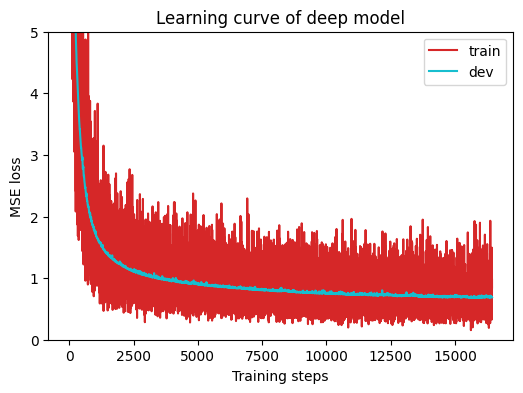

Saving results to submission.csv
Results saved to ml2021spring-hw1_files\submission.csv
[ 0.0116952  -0.40885505 -0.40124086 -0.29837012 -1.0065885  -0.11940578
 -0.2487438  -0.2871149  -0.4532913   0.04838456 -0.09726672 -0.5334408
 -0.08321743 -0.41014063 -0.09904706 -0.223782   -0.31003904 -0.40024322
 -0.00793766 -1.0041234  -0.17141294 -0.26279044 -0.26060873  0.02943657
 -0.25973248 -0.10058607 -0.50034434 -0.35399818 -0.37441778 -0.0691682
 -0.30419728 -0.1894675  -0.2718078  -0.0563874  -0.6170326  -0.21805248
 -0.31875953 -0.16092366 -0.0168214  -0.36286655 -0.41992736 -0.38767523
 -0.26997176 -0.19760245 -0.20294434 -0.05922019 -0.34805554 -0.77101356
 -0.63039047 -0.1884392  -0.15703115 -0.26276946 -0.32847336 -0.39837682
 -0.1398142  -0.50052845 -0.3795335  -0.20928162 -0.08998947 -0.3319827
 -0.6598304  -0.45053822 -0.19963737 -0.08649382 -0.2012819  -0.7195888
 -0.20202617 -0.2759037  -0.26967394 -0.10781142 -0.03597701 -0.31952825
 -0.34322828 -0.16828835 -0.18757801 -0.

In [49]:
def save_pred(preds,file_path):
    print('Saving results to submission.csv')
    submission_path = os.path.join(file_path, 'submission.csv')  
    df = pd.DataFrame({'id':range(len(preds)),'tested_positive':preds[:]})
    df.to_csv(submission_path, index=False)
    print(f'Results saved to {submission_path}')
 
plot_learning_curve(model_loss_record,title = 'deep model')
model = NeuralNet(tr_set.dataset.dim).to(device)
preds = test(tt_set,model,device)
save_pred(preds,file_path)
print(preds)